# Quantum Segmentation for medical imaging

In this notebook, we will learn to perform image segmentation with an unsupervised method based on quantum annealing. The code from this notebook is adapted from Ref. [1].

According to a 2020 study by Johns Hopkins University, diagnostic errors affect 12 million US adults each year. This study does not include the misdiagnosis happening in the rest of the world. Misdiagnosis can have serious consequences for patients, including delayed or inappropriate treatment, unnecessary interventions and increased healthcare costs. This underscores the need for more accurate, quicker diagnosis to ensure patient safety.

Developing efficient solutions for breast cancer diagnosis is crucial given its widespread occurrence and challenges in detection. Shockingly, a significant 85% of breast cancers occur in women with no family history of the disease, emphasizing the need for universal screening methods to ensure early detection. Considering that approximately half of all women aged 40+ are vulnerable to breast cancer, accurate and reliable diagnostic tools are imperative. However, studies reveal alarming discrepancies in visual assessments by radiologists using existing technologies, with agreement rates varying widely from 6% to 85%. Such extreme inconsistencies highlight the urgent need to improve diagnostic outcomes for affected individuals.

Segmentation is the process of identifying and delineating areas of interest within an image. In the context of breast cancer, segmentation tasks primarily involve identifying and outlining masses within the breast tissue and distinguishing benign from malignant masses.

The emdical imaging pipeline consists of two steps:

+ **1. Object detection:** Consists of detecting the region of interest that may contain a tumor.
+ **2. Image segmentation:** Consists of identifying the exact shape of the tumor within the image.

In this notebook, we will focus on step 2, which will be done using quantum annealing.

!["Medical Imaging pipeline"](Medical_Imaging_Pipeline.PNG)


[1] [Venkatesh, S. M., Macaluso, A., Nuske, M., Klusch, M., & Dengel, A. (2023). Q-Seg: Quantum Annealing-based Unsupervised Image Segmentation. arXiv preprint arXiv:2311.12912](https://arxiv.org/abs/2311.12912)

In [26]:
#pip install dwave-system

## Quantum annealing pipeline

The pipeline consists of several key steps:

1. **Converting the Image to Graph**: The image is first translated into an undirected, weighted, connected grid-graph wtih the pixels correspond to vertices and the edge weights are assigned between neighboring pixels using an appropriate similarity metric.
2. **Reformulating the Minimum Cut Problem**: The segmentation task is converted into a Quadratic Unconstrained Binary Optimization (QUBO) problem.
2. **Remote Access Authentication**: A private token is used for secure remote access to the D-Wave quantum annealer.
3. **Qubit Mapping**: The `minorminer` tool maps the logical qubits in the QUBO to the physical qubits in the D-Wave hardware.
4. **Problem Submission and Queuing**: The problem instance is transmitted over the internet and queued on the shared D-Wave device.
5. **Quantum Annealing**: The Quantum Processing Unit (QPU) on the D-Wave device performs the annealing process.
6. **Solution Extraction**: The retrieval of the sample set produced by the QPU and extracting the optimal solution based on the lowest energy state.
7. **Solution Decode**: The final step involves lowest energy binary solution string being decoded into a binary segmentation mask.

### Import packages

In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Additional necessary imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_optimization.applications import Maxcut
import dimod
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import time
import cv2

The following helper functions allow to create a graph of the input image.
Given an $n \times m$ input image, we create an undirected weighted graph $G$ where each pixel of the image corresponds to a node in the graph. Afterwards, we add an edge between all adjhacent pixels. The weight is calculated by using Gaussian similarity between pixels, such that:

$$
s(x,y) = e^\frac{-(x-y)^2}{2\sigma^2}
$$

where $\sigma$ is the standard deviation, an hyperparameter of the model.

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity

def gaussian_similarity(a, b, sigma):
  """
  Calculate the Gaussian similarity score between two values.

  The Gaussian similarity function is often used in image processing and graph-based algorithms
  to measure how close or similar two values (like pixel intensities) are to each other.

  Parameters:
  a (float): The first value.
  b (float): The second value.
  sigma (float): The standard deviation used in the Gaussian function. This parameter controls
                 how quickly the similarity score decreases with the difference between a and b.

  Returns:
  float: The Gaussian similarity score between a and b.
  """
  gaussian_similairity_score = np.exp(-((a - b)**2) / (2 * sigma**2))
  return gaussian_similairity_score




def image_to_grid_graph(gray_img, kernel = False,sigma=0.5):
  """
  Convert a grayscale image to a grid graph with Gaussian similarity as edge weights.

  Parameters:
  gray_img (numpy.ndarray): Grayscale image.
  sigma (float): Parameter for Gaussian similarity.

  Returns:
  list: List of edges with weights for the graph.
  """
  h, w = gray_img.shape
  nodes = np.zeros((h*w, 1))
  edges = []
  nx_elist = []
  min_weight = 1
  max_weight = 0
  for i in range(h*w):
    x, y = i//w, i%w
    nodes[i] = gray_img[x,y]
    if x > 0:
      j = (x-1)*w + y
      weight = -1*(1-gaussian_similarity(gray_img[x,y], gray_img[x-1,y], sigma))
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x-1,y),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
    if y > 0:
      j = x*w + y-1
      weight = -1*(1-gaussian_similarity(gray_img[x,y], gray_img[x,y-1], sigma))
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x,y-1),weight))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
  a=-1
  b=1
  if max_weight-min_weight:
    normalized_nx_elist = [(node1,node2,np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,4)) for node1,node2,edge_weight in nx_elist]
  elif max_weight==0 and min_weight==0:
    normalized_nx_elist = [(node1,node2,1) for node1,node2,edge_weight in nx_elist]
  else:
    normalized_nx_elist = [(node1,node2,np.round(edge_weight,4)) for node1,node2,edge_weight in nx_elist]
  return normalized_nx_elist

def draw(G, image):
  """
  Draw the graph G with the given image as node colors.

  Parameters:
  G (networkx.Graph): Graph to be drawn.
  image (numpy.ndarray): Grayscale image for node colors.
  """
  pixel_values = image
  plt.figure(figsize=(min(12,2*image.shape[0]),min(12,2*image.shape[0])))
  default_axes = plt.axes(frameon=True)
  pos = {(x,y):(y,-x) for x,y in G.nodes()}
  nx.draw_networkx(G,
                  pos=pos,
                  node_color=1-pixel_values,
                  with_labels=True,
                  node_size=1200,
                  cmap=plt.cm.Greys,
                  alpha=0.5,
                  ax=default_axes)
  nodes = nx.draw_networkx_nodes(G, pos, node_color=1-pixel_values,
                  node_size=1200,
                  cmap=plt.cm.Greys)
  nodes.set_edgecolor('k')
  edge_labels = nx.get_edge_attributes(G, "weight")
  nx.draw_networkx_edge_labels(G,
                              pos=pos,
                             edge_labels=edge_labels)


def draw_graph_cut_edges(G, image, cut_edges):
  """
  Draw the graph G with the given image as node colors, with the cut edges depicted as red dashed lines.

  Parameters:
  G (networkx.Graph): Graph to be drawn.
  image (numpy.ndarray): Grayscale image for node colors.
  cut_edges (list): Each tuple in the list contains two nodes corresponds to an edge that is cut.
  """
  pixel_values = image
  plt.figure(figsize=(min(12,2*image.shape[0]),min(12,2*image.shape[0])))
  default_axes = plt.axes(frameon=True)
  pos = {(x,y):(y,-x) for x,y in G.nodes()}
  nx.draw_networkx(G,
                  pos=pos,
                  node_color=1-pixel_values,
                  with_labels=True,
                  node_size=1200,
                  cmap=plt.cm.Greys,
                  alpha=0.8,
                  ax=default_axes)
  nodes = nx.draw_networkx_nodes(G, pos, node_color=1-pixel_values,
                  node_size=1200,
                  cmap=plt.cm.Greys)
  nodes.set_edgecolor('k')
  nx.draw_networkx_edges(G,
                         pos=pos,
                         edgelist=cut_edges,
                         width=6,
                         alpha=0.5,
                         edge_color="r",
                         style="dashed")
  edge_labels = nx.get_edge_attributes(G, "weight")
  nx.draw_networkx_edge_labels(G,
                               pos=pos,
                               edge_labels=edge_labels)

## Import sample data

We start by importing the input image (ROI) and the desired mask. In order to use D-wave's real hardware, we need to downscale the image so that it fits the annealer's topology. In this example, we will downsample the image to $32 \times 32$ pixels.

In [10]:
# Load image and mask
image = cv2.imread('ROI.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('mask.png', cv2.IMREAD_GRAYSCALE)
# Scale to [0,1] domain
data = image.reshape(256,256)/255
mask = mask.reshape(256,256)/255

In [11]:
height,width = 32,32
# Downscale image and mask
data_small = cv2.resize(data, (height,width))
mask_small = cv2.resize(mask, (height,width))

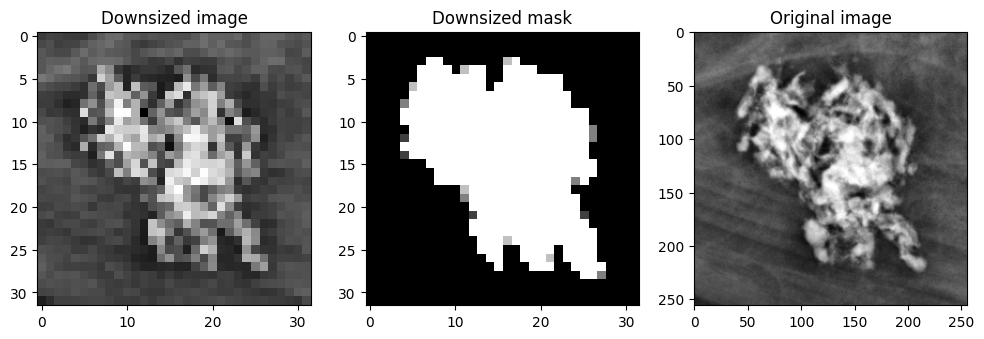

In [12]:
# Plot the results
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
ax1.imshow(data_small, cmap=plt.cm.gray)
ax1.set_title('Downsized image')
ax2.imshow(mask_small, cmap=plt.cm.gray)
ax2.set_title('Downsized mask')
ax3.imshow(data, cmap=plt.cm.gray)
ax3.set_title('Original image')
plt.show()

## Convert Image to Graph

Now, we will use the helper functions to create the graph.

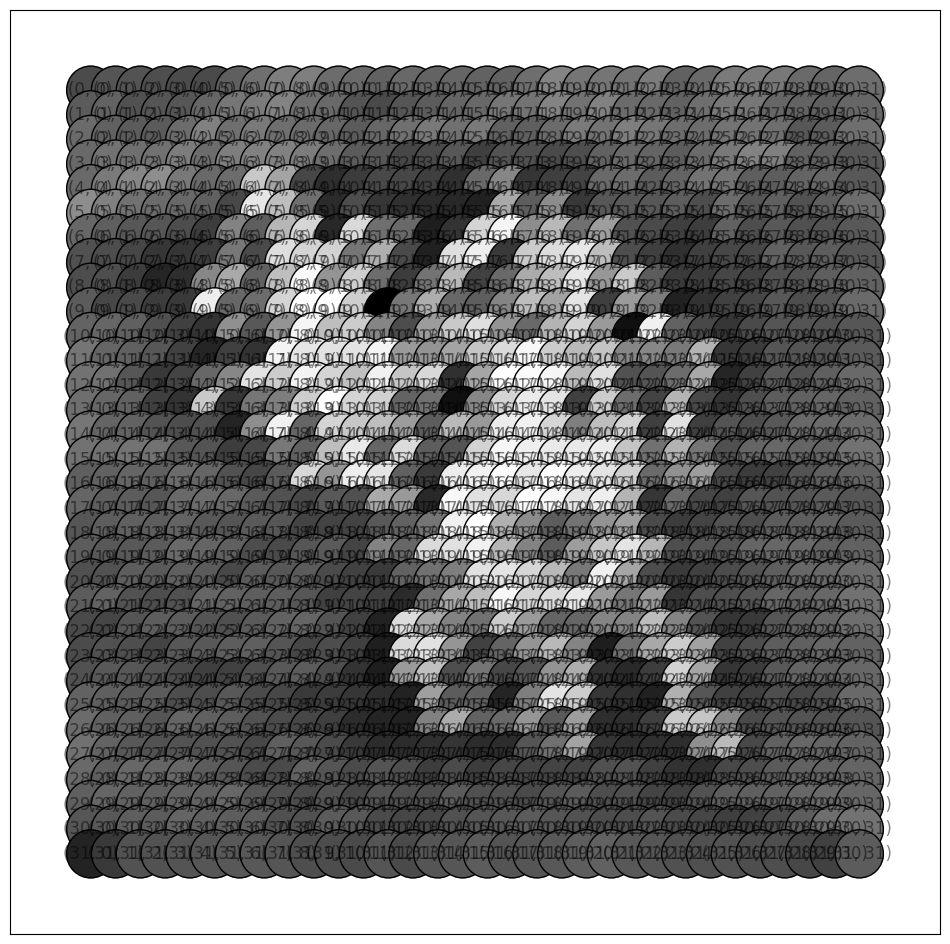

In [18]:
# Create weights
normalized_nx_elist = image_to_grid_graph(data_small, sigma=np.std(data_small.flatten()))  # We are using Guassian similarity metric as the edge weight metric
# Create graph
G = nx.grid_2d_graph(data_small.shape[0], data_small.shape[1])
# Add weights
G.add_weighted_edges_from(normalized_nx_elist)
draw(G, data_small)

## Formulate MinCut problem

We formulate the pixel-segmentation problem as a mincut problem (the opposite of a maxcut). 
The segmentation tasks consists of finding the cut in the graph that provides minimum similarity between the two different classes. $𝑥_𝑖=0$ means that pixel $i$ belongs to the first class, and $𝑥_𝑖=1$ means that it belongs to the second class. Therefore, the problem is mapped to a min-cut problem. The segmentation process is unsupervised, so that no labelled data is needed. 

The problem is formulated as a QUBO problem. Let $𝑥_𝑖$ be a binary variable for vertex $𝑖$, and let $\omega_{ij}$ be the edje between node $i$ and node $j$. Then, the solution is encoded by minimizing the following formula:

$$
x^* = \argmin_x \sum_{ij} x_i(1-x_j)w_{i,j} + \sum_i w_{i,i}x_i
$$

Let's formulate the problem:

In [19]:
start_time = time.time()
n = height * width 
# Get adjacency matrix
w = nx.adjacency_matrix(G).todense()
linear = {}
quadratic = {}
for i in range(n):
    linear[i] = 0
    for j in range(n):
        linear[i] += w[i,j] # Calculate linear constraint
        if w[i,j]!=0 and j>i:
            quadratic[(i,j)] = -w[i,j]*2 # Calculate quadratic constraint
    linear[i] = round(linear[i],2)
problem_formulation_time = time.time() - start_time

## Run with D-Wave annealer

The next step is to run the optimization problem using quantum annealing. In order to run this in a real device, you will need to register in D-wave and get a token.

To register, go to: https://cloud.dwavesys.com/leap/login/?next=/leap/  and create an account.
Then, go to your dashboard (https://cloud.dwavesys.com/leap/) and copy the private token. Paste it in your `private_token` variable in the next cell.

In [20]:
private_token = 'your-token-here'
runs = 2000

# Define quadratic model
vartype = dimod.BINARY
bqm = dimod.BinaryQuadraticModel(linear, quadratic, 0.0, vartype)

# Define sampler
dwave_sampler = DWaveSampler(token = private_token, solver={'topology__type': 'pegasus'})
connection_time = time.time() - start_time
start_time = time.time()
# Embedding to quantum device
sampler = EmbeddingComposite(dwave_sampler)
embedding_time = time.time() - start_time

# Sample
start_time = time.time()
sample_set = sampler.sample(bqm, num_reads=runs)
response_time = time.time() - start_time

## Construct dictionary

Now that we have run the optimization in D-wave's annealer, we will get the results and create a dictionary containing all the times used to perform the optimization process.

In [21]:
info_dict = sample_set.info['timing'].copy()

start_time = time.time()
samples_dataframe = sample_set.to_pandas_dataframe()
sample_fetch_time = time.time() - start_time

info_dict['problem_formulation_time'] = problem_formulation_time
info_dict['connection_time'] = connection_time
info_dict['embedding_time'] = embedding_time
info_dict['response_time'] = response_time
info_dict['sample_fetch_time'] = sample_fetch_time
info_dict

{'qpu_sampling_time': 411640.0,
 'qpu_anneal_time_per_sample': 20.0,
 'qpu_readout_time_per_sample': 165.24,
 'qpu_access_time': 427568.37,
 'qpu_access_overhead_time': 3267.63,
 'qpu_programming_time': 15928.37,
 'qpu_delay_time_per_sample': 20.58,
 'post_processing_overhead_time': 19.0,
 'total_post_processing_time': 19.0,
 'problem_formulation_time': 0.9345812797546387,
 'connection_time': 65.66738820075989,
 'embedding_time': 0.15261149406433105,
 'response_time': 23.96597456932068,
 'sample_fetch_time': 0.013000965118408203}

## Obtain binary segmentation mask

The last step consists of mapping the binary strings to a binary segmentation mask. We will use the following helper function to do so. Then, we will visualize the results.

In [22]:
def decode_binary_string(x, height, width):
    """
    Decode a binary string into a binary segmentation mask.

    Parameters:
    x (list): Binary string representing the segmentation.
    height (int): Height of the image.
    width (int): Width of the image.

    Returns:
    numpy.ndarray: Segmentation mask.
    """
    mask = np.zeros([height, width])
    for index, segment in enumerate(x):
        mask[index // width, index % width] = segment
    return mask


## Plot the results

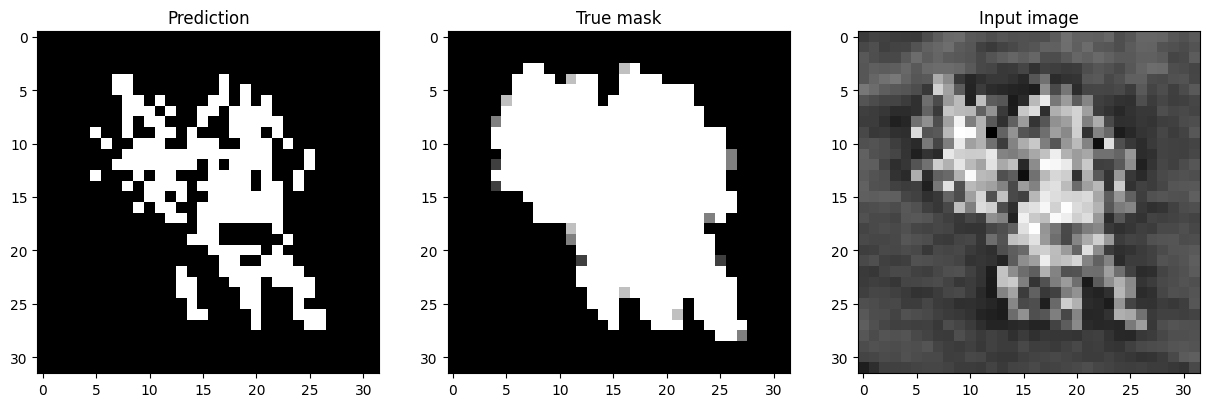

In [25]:
solution_binary_string = samples_dataframe.iloc[0][:-3]
segmentation_mask = decode_binary_string(solution_binary_string, height, width)
segmentation_mask = (segmentation_mask+1)%2

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.imshow(segmentation_mask, cmap=plt.cm.gray)
ax1.set_title('Prediction')
ax2.imshow(mask_small, cmap=plt.cm.gray)
ax2.set_title('True mask')
ax3.imshow(data_small, cmap=plt.cm.gray)
ax3.set_title('Input image')
plt.show()

## Exercise: Simulated annealing

We have performed the optimization process using the real D-wave's machine. In this exercise, you are asked to perform the same segmentation process using D-wave's `SimulatedAnnealingSampler`, which uses simulated annealing to perform the optimization. Compare execution times with the annealer. You can also try to obtain the segmentation mask using larger images ($64 \times 64$, for example).